In [1]:
import warnings

warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import torch

from torch.optim import AdamW
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import v2, ToTensor
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_ef import FCFE
from forest_cover_change_detection.trainer.train import Compile

### Loading Data

In [2]:
train_transform = v2.Compose([v2.ColorJitter(brightness=.5, hue=.3),
                              v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
                              v2.RandomInvert(),
                              # ToTensor()
                              ])

In [2]:
data_set = ChangeDetectionDataset('../data/annotated',
                                  '../data/train.csv',
                                  # train_transform
                                  )

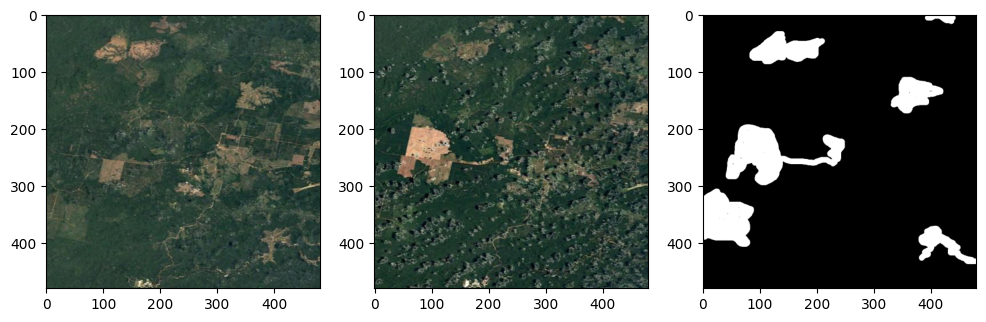

In [3]:
img, label = data_set[4]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(img[:3, ::].permute(1, 2, 0).numpy())
axes[1].imshow(img[3:, ::].permute(1, 2, 0).numpy())
axes[2].imshow(label.permute(1, 2, 0).numpy(), cmap='gray')

In [4]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
model = FCFE(6, 3)

In [7]:
compiled = Compile(model,
                   AdamW(model.parameters(), lr=0.001)
                   )

In [8]:
compiled.summary((6, 480, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 480, 480]             880
       BatchNorm2d-2         [-1, 16, 480, 480]              32
            Conv2d-3         [-1, 16, 480, 480]           2,320
       BatchNorm2d-4         [-1, 16, 480, 480]              32
         MaxPool2d-5         [-1, 16, 240, 240]               0
            Conv2d-6         [-1, 32, 240, 240]           4,640
       BatchNorm2d-7         [-1, 32, 240, 240]              64
            Conv2d-8         [-1, 32, 240, 240]           9,248
       BatchNorm2d-9         [-1, 32, 240, 240]              64
        MaxPool2d-10         [-1, 32, 120, 120]               0
           Conv2d-11         [-1, 64, 120, 120]          18,496
      BatchNorm2d-12         [-1, 64, 120, 120]             128
           Conv2d-13         [-1, 64, 120, 120]          36,928
      BatchNorm2d-14         [-1, 64, 1

In [ ]:
results = compiled.train(train_dataloader, 
                         nn.BCEWithLogitsLoss(), 
                         300, 
                         test_dataloader)

In [11]:
img = test_dataset[0][0]

with torch.no_grad():
    logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.sigmoid(logits) >= 0.5

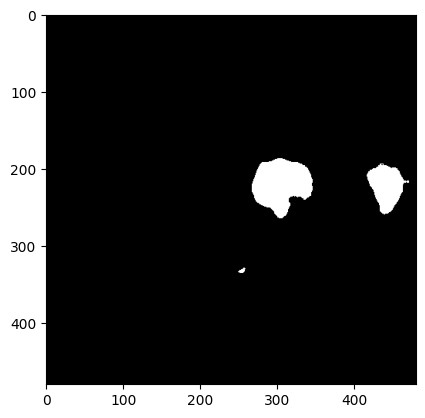

In [13]:
plt.imshow(pred.permute(1, 2, 0).numpy(), cmap='gray')

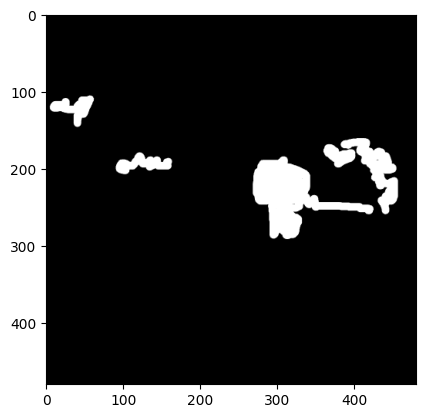

In [16]:
plt.imshow(test_dataset[0][1].permute(1, 2, 0).numpy(), cmap='gray')